# Getting started with TinyTimeMixer (TTM)

This notebooke demonstrates the usage of a pre-trained `TinyTimeMixer` model for several multivariate time series forecasting tasks. For details related to model architecture, refer to the [TTM paper](https://arxiv.org/pdf/2401.03955.pdf).

In this example, we will use a pre-trained TTM-512-96 model. That means the TTM model can take an input of 512 time points (`context_length`), and can forecast upto 96 time points (`forecast_length`) in the future. We will use the pre-trained TTM in two settings:
1. **Zero-shot**: The pre-trained TTM will be directly used to evaluate on the `test` split of the target data. Note that the TTM was NOT pre-trained on the target data.
2. **Few-shot**: The pre-trained TTM will be quickly fine-tuned on only 5% of the `train` split of the target data, and subsequently, evaluated on the `test` part of the target data.

Note: Alternatively, this notebook can be modified to try any other TTM model from a suite of TTM models. For details, visit the [Hugging Face TTM Model Repository](https://huggingface.co/ibm-granite/granite-timeseries-ttm-r2).

1. IBM Granite TTM-R1 pre-trained models can be found here: [Granite-TTM-R1 Model Card](https://huggingface.co/ibm-granite/granite-timeseries-ttm-r1)
2. IBM Granite TTM-R2 pre-trained models can be found here: [Granite-TTM-R2 Model Card](https://huggingface.co/ibm-granite/granite-timeseries-ttm-r2)
3. Research-use (non-commercial use only) TTM-R2 pre-trained models can be found here: [Research-Use-TTM-R2](https://huggingface.co/ibm-research/ttm-research-r2)

### The get_model() utility
TTM Model card offers a suite of models with varying `context_length` and `prediction_length` combinations.
In this notebook, we will utilize the TSFM `get_model()` utility that automatically selects the right model based on the given input `context_length` and `prediction_length` (and some other optional arguments) abstracting away the internal complexity. See the usage examples below in the `zeroshot_eval()` and `fewshot_finetune_eval()` functions. For more details see the [docstring](https://github.com/ibm-granite/granite-tsfm/blob/main/tsfm_public/toolkit/get_model.py) of the function definition.

## Install `tsfm`
**[Optional for Local Run / Mandatory for Google Colab]**  
Run the below cell to install `tsfm`. Skip if already installed.

In [4]:
# Install the tsfm library
! pip install "granite-tsfm[notebooks] @ git+https://github.com/ibm-granite/granite-tsfm.git@v0.3.1"

  Cloning https://github.com/ibm-granite/granite-tsfm.git (to revision v0.3.1) to /tmp/pip-install-c991typ4/granite-tsfm_afd53f6e0b014c658715af6d20675e72
  Running command git clone --filter=blob:none --quiet https://github.com/ibm-granite/granite-tsfm.git /tmp/pip-install-c991typ4/granite-tsfm_afd53f6e0b014c658715af6d20675e72
  Running command git checkout -q 16106d70d1fb3244eecd48c8fbbf3a0009fb8751
  Resolved https://github.com/ibm-granite/granite-tsfm.git to commit 16106d70d1fb3244eecd48c8fbbf3a0009fb8751
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.5/51.5 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.3/51.3 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 108.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 76.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Imports

In [1]:
import math
import os
import tempfile

import pandas as pd
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments, set_seed
from transformers.integrations import INTEGRATION_TO_CALLBACK

from tsfm_public.toolkit import TimeSeriesPreprocessor, TrackingCallback, count_parameters, get_datasets
from tsfm_public.toolkit.get_model import get_model
from tsfm_public.toolkit.lr_finder import optimal_lr_finder
from tsfm_public.toolkit.visualization import plot_predictions
from icecream import ic

In [2]:
import warnings


# Suppress all warnings
warnings.filterwarnings("ignore")

In [23]:
!pip install icecream

In [24]:
from icecream import ic

### Important arguments

In [35]:
# Set seed for reproducibility
SEED = 42
set_seed(SEED)

# TTM Model path. The default model path is Granite-R2. Below, you can choose other TTM releases.
TTM_MODEL_PATH = "ibm-granite/granite-timeseries-ttm-r2"

# Context length, Or Length of the history.
# Currently supported values are: 512/1024/1536 for Granite-TTM-R2 and Research-Use-TTM-R2, and 512/1024 for Granite-TTM-R1
CONTEXT_LENGTH = 1536

# Granite-TTM-R2 supports forecast length upto 720 and Granite-TTM-R1 supports forecast length upto 96
PREDICTION_LENGTH = 204

TARGET_DATASET = "etth1"
dataset_path = "https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTh1.csv"


# Results dir
OUT_DIR = "ttm_finetuned_models/"

# Data processing

In [48]:
# Dataset
TARGET_DATASET = "train"
dataset_path = "./train_001.csv"
timestamp_column = "일시"
id_columns = []  # mention the ids that uniquely identify a time-series.
control_columns = ["기온(°C)","강수량(mm)","풍속(m/s)","습도(%)"]
target_columns = ["전력소비량(kWh)"]
split_config = {
    "train": [0, 1536],
    "valid": [1536, 1836],
    "test": [
        1836,
        2040,
    ],
}
# Understanding the split config -- slides

data = pd.read_csv(
    dataset_path,
    parse_dates=[timestamp_column],
)
data.drop('num_date_time', axis=1, inplace=True)

column_specifiers = {
    "timestamp_column": timestamp_column,
    "id_columns": id_columns,
    "target_columns": target_columns,
    "control_columns": control_columns,
}

In [49]:
print(data.head())
print(data.info())

   건물번호                  일시  기온(°C)  강수량(mm)  풍속(m/s)  습도(%)  일조(hr)  \
0     1 2024-06-01 00:00:00    18.3      0.0      2.6   82.0     0.0   
1     1 2024-06-01 01:00:00    18.3      0.0      2.7   82.0     0.0   
2     1 2024-06-01 02:00:00    18.1      0.0      2.6   80.0     0.0   
3     1 2024-06-01 03:00:00    18.0      0.0      2.6   81.0     0.0   
4     1 2024-06-01 04:00:00    17.8      0.0      1.3   81.0     0.0   

   일사(MJ/m2)  전력소비량(kWh)  
0        0.0     5794.80  
1        0.0     5591.85  
2        0.0     5338.17  
3        0.0     4554.42  
4        0.0     3602.25  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2040 entries, 0 to 2039
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   건물번호        2040 non-null   int64         
 1   일시          2040 non-null   datetime64[ns]
 2   기온(°C)      2040 non-null   float64       
 3   강수량(mm)     2040 non-null   float64       
 4   풍속(m/s

## Zero-shot evaluation method

In [50]:
column_specifiers

{'timestamp_column': '일시',
 'id_columns': [],
 'target_columns': ['전력소비량(kWh)'],
 'control_columns': ['기온(°C)', '강수량(mm)', '풍속(m/s)', '습도(%)']}

In [51]:
def zeroshot_eval(dataset_name, batch_size, context_length=512, forecast_length=96):
    # Get data
    tsp = TimeSeriesPreprocessor(
        **column_specifiers,
        context_length=context_length,
        prediction_length=forecast_length,
        scaling=True,
        encode_categorical=False,
        scaler_type="standard",
    )
    # Load model
    zeroshot_model = get_model(
        TTM_MODEL_PATH,
        context_length=context_length,
        prediction_length=forecast_length,
        freq_prefix_tuning=False,
        freq=None,
        prefer_l1_loss=False,
        prefer_longer_context=True,
    )
    dset_train, dset_valid, dset_test = get_datasets(
        tsp, data, split_config, use_frequency_token=zeroshot_model.config.resolution_prefix_tuning
    )
    print("dset_train=","shape=",dset_train.group_df.size(),dset_train.group_df.head())
    print("dset_valid=","shape=",dset_valid.group_df.size(),dset_valid.group_df.head())
    print("dset_test=","shape=",dset_test.group_df.size(),dset_test.group_df.head())
    temp_dir = tempfile.mkdtemp()
    # zeroshot_trainer
    zeroshot_trainer = Trainer(
        model=zeroshot_model,
        args=TrainingArguments(
            output_dir=temp_dir,
            per_device_eval_batch_size=batch_size,
            seed=SEED,
            report_to="none",
        ),
    )
    # evaluate = zero-shot performance
    print("+" * 20, "Test MSE zero-shot", "+" * 20)
    zeroshot_output = zeroshot_trainer.evaluate(dset_test)
    print("zeroshot_output=", zeroshot_output)
    # get predictions
    predictions_dict = zeroshot_trainer.predict(dset_test)
    predictions_np = predictions_dict.predictions[0]
    print("predictions_np.shape=",predictions_np.shape)
    # get backbone embeddings (if needed for further analysis)
    backbone_embedding = predictions_dict.predictions[1]
    print("backbone_embedding.shape=",backbone_embedding.shape)
    # plot
    """
    plot_predictions(
        model=zeroshot_trainer.model,
        dset=dset_test,
        plot_dir=os.path.join(OUT_DIR, dataset_name),
        plot_prefix="test_zeroshot",
        indices=[685, 118, 902, 1984, 894, 967, 304, 57, 265, 1015],
        channel=0,
    )
    """
    # zeroshot_trainer와 tsp를 함께 반환
    return dset_train, dset_valid, dset_test, predictions_dict, zeroshot_trainer, tsp

In [52]:
# 1. 수정된 zeroshot_eval 함수 호출
dset_train, dset_valid, dset_test, predictions_dict, zeroshot_trainer, tsp = zeroshot_eval(
    dataset_name=TARGET_DATASET, context_length=CONTEXT_LENGTH, forecast_length=PREDICTION_LENGTH, batch_size=64
)

INFO:/usr/local/lib/python3.12/dist-packages/tsfm_public/toolkit/get_model.py:Loading model from: ibm-granite/granite-timeseries-ttm-r2
INFO:/usr/local/lib/python3.12/dist-packages/tsfm_public/toolkit/get_model.py:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = 1536-336-r2.
INFO:/usr/local/lib/python3.12/dist-packages/tsfm_public/toolkit/get_model.py:[TTM] context_length = 1536, prediction_length = 336


dset_train= shape= group
0    1536
dtype: int64    건물번호                  일시    기온(°C)   강수량(mm)   풍속(m/s)     습도(%)  일조(hr)  \
0     1 2024-06-01 00:00:00 -2.064204 -0.182304  0.170603  0.627952     0.0   
1     1 2024-06-01 01:00:00 -2.064204 -0.182304  0.261340  0.627952     0.0   
2     1 2024-06-01 02:00:00 -2.119400 -0.182304  0.170603  0.511378     0.0   
3     1 2024-06-01 03:00:00 -2.146999 -0.182304  0.170603  0.569665     0.0   
4     1 2024-06-01 04:00:00 -2.202195 -0.182304 -1.008970  0.569665     0.0   

   일사(MJ/m2)  전력소비량(kWh)  group  
0        0.0    0.602845      0  
1        0.0    0.379264      0  
2        0.0    0.099795      0  
3        0.0   -0.763630      0  
4        0.0   -1.812596      0  
dset_valid= shape= group
0    1836
dtype: int64    건물번호                  일시    기온(°C)   강수량(mm)   풍속(m/s)     습도(%)  일조(hr)  \
0     1 2024-06-01 00:00:00 -2.064204 -0.182304  0.170603  0.627952     0.0   
1     1 2024-06-01 01:00:00 -2.064204 -0.182304  0.261340  0.627952

zeroshot_output= {'eval_loss': 0.4858996272087097, 'eval_model_preparation_time': 0.0022, 'eval_runtime': 0.025, 'eval_samples_per_second': 39.992, 'eval_steps_per_second': 39.992}
predictions_np.shape= (1, 204, 5)
backbone_embedding.shape= (1, 5, 12, 384)


In [60]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_predictions_from_eval(
    data, dset_test, predictions_dict, split_config, building_id, forecast_length, tsp
):
    """
    zeroshot_eval의 반환 값과 원본 데이터를 사용하여 예측 결과를 시각화합니다.
    Args:
        data (pd.DataFrame): 모든 데이터가 합쳐진 원본 DataFrame.
        dset_test (Dataset): zeroshot_eval에서 반환된 테스트 데이터셋.
        predictions_dict (dict): zeroshot_eval에서 반환된 예측 결과.
        split_config (dict): 데이터 분할 설정.
        building_id (int): 시각화할 건물 번호.
        forecast_length (int): 예측 길이.
        tsp (TimeSeriesPreprocessor): 데이터 전처리 객체.
    """
    # 1. 모델에 입력된 과거 데이터(context) 추출
    context_length = split_config['valid'][0] - split_config['train'][0]
    start_test_idx = split_config['test'][0]
    historical_df = data.iloc[start_test_idx - context_length : start_test_idx].copy()

    # 2. 예측 기간에 해당하는 실제값(정답) 데이터 추출
    ground_truth_df = data.iloc[start_test_idx : start_test_idx + forecast_length].copy()

    # 3. predictions_dict에서 예측 결과 추출
    predictions_for_plot = predictions_dict.predictions[0][0, :, 0]

    # --- 언스케일링 과정 ---
    # id_columns가 없으므로, 키는 '0'입니다.
    target_scaler = tsp.target_scaler_dict['0']
    predictions_for_plot = predictions_for_plot.reshape(-1, 1)
    unscaled_predictions = target_scaler.inverse_transform(predictions_for_plot).flatten()

    # 4. 데이터 시각화
    plt.figure(figsize=(15, 6))

    # 과거 데이터와 미래의 실제값을 합쳐서 '실제값' 라인으로 플롯
    full_ground_truth_df = pd.concat([historical_df, ground_truth_df])
    plt.plot(full_ground_truth_df['일시'], full_ground_truth_df['전력소비량(kWh)'], label='실제값', color='blue')

    # 예측값을 플롯
    forecast_timestamps = pd.date_range(start=historical_df['일시'].iloc[-1], periods=forecast_length + 1, freq='H')[1:]
    plt.plot(forecast_timestamps, unscaled_predictions, label='예측값', color='red', linestyle='--')

    # 제목 및 라벨
    plt.title(f'건물 {building_id}의 전력소비량 예측', fontsize=16)
    plt.xlabel('일시', fontsize=12)
    plt.ylabel('전력소비량 (kWh)', fontsize=12)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

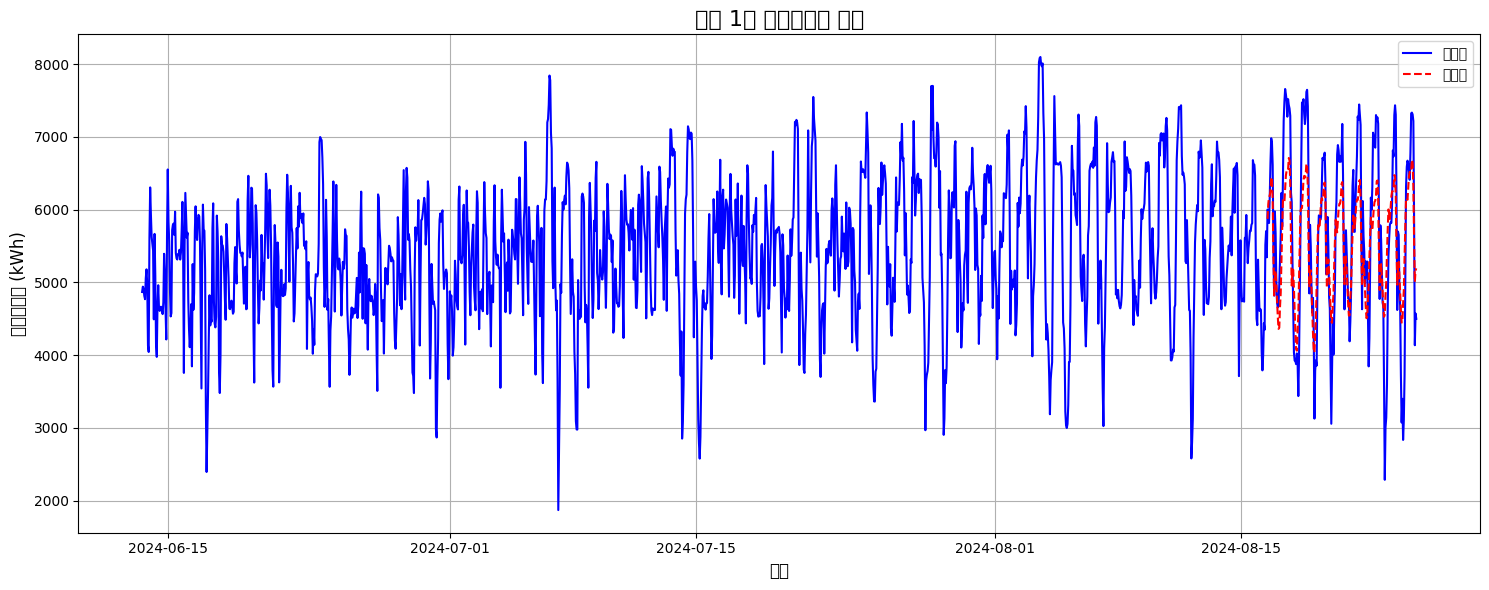

In [61]:

plot_predictions_from_eval(
    data=data,
    dset_test=dset_test,
    predictions_dict=predictions_dict,
    split_config=split_config,
    building_id=1,
    forecast_length=PREDICTION_LENGTH,
    tsp=tsp
)

In [62]:
import numpy as np

def calculate_smape(y_true, y_pred):
    """
    SMAPE (Symmetric Mean Absolute Percentage Error)를 계산합니다.
    Args:
        y_true (np.ndarray): 실제 값
        y_pred (np.ndarray): 예측 값
    Returns:
        float: SMAPE 값 (백분율)
    """
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2

    # 분모가 0인 경우를 처리하여 NaN을 방지합니다.
    smape_values = np.where(denominator == 0, 0, numerator / denominator)

    return np.mean(smape_values) * 100

In [63]:
# 2. SMAPE 계산
# 실제값(Ground Truth)과 예측값(Prediction)을 추출 및 언스케일링합니다.

# 예측 기간에 해당하는 실제값(정답) 데이터 추출
start_test_idx = split_config['test'][0]
forecast_length = split_config['test'][1] - split_config['test'][0]
ground_truth_df = data.iloc[start_test_idx : start_test_idx + forecast_length].copy()

# 실제값 배열 추출
y_true = ground_truth_df['전력소비량(kWh)'].values

# 예측값 배열 추출 및 언스케일링
predictions_for_plot = predictions_dict.predictions[0][0, :, 0]
target_scaler = tsp.target_scaler_dict['0']
predictions_for_plot = predictions_for_plot.reshape(-1, 1)
y_pred = target_scaler.inverse_transform(predictions_for_plot).flatten()

# 3. SMAPE 계산 및 출력
smape_value = calculate_smape(y_true, y_pred)
print(f"\nSMAPE (Symmetric Mean Absolute Percentage Error): {smape_value:.2f}%")


SMAPE (Symmetric Mean Absolute Percentage Error): 11.11%
